# Mount Google Drive

In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Access Source data folder
%cd /content/gdrive/MyDrive/CollectiveBehaviour/CollectiveBehaviour-main

/content/gdrive/.shortcut-targets-by-id/1eYVarrWVUjaGSBkS8zIMZBZ1iaMGyrnO/CollectiveBehaviour/CollectiveBehaviour-main


In [3]:
path = '/content/gdrive/MyDrive/CollectiveBehaviour/'

# Imports and initialize variables

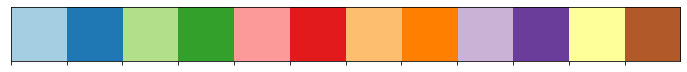

In [4]:
import numpy as np

import pandas as pd
import os
import glob
import scipy
import gzip
import pickle

import seaborn as sns
import matplotlib.pyplot as plt 
import ipywidgets as widgets#  HBox, VBox, IntSlider, Play, jslink, Layout, Label
from IPython.display import display , HTML
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


import raycastingfunctions as rc
import detectionfunctions as detection
import importlib
import gc

import time

snscolors = sns.color_palette()
pairedcolors=sns.color_palette("Paired")
sns.palplot(pairedcolors)

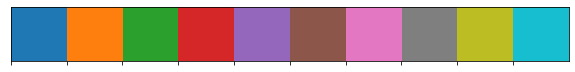

In [19]:
# common definitions
allnumfish=[10,30,70,151]
cmperpixel = 210/1870  # see 'images/pxpercm-conversion.pdf'

pairedcolors=sns.color_palette("Paired")
sns.palplot(snscolors)

In [6]:

# import
#home = os.path.expanduser("~")
trials=['10-fish/0066/','/10-fish/0105/','/10-fish/0126/','30-fish/0084/','/30-fish/0115/','/30-fish/0120/','70-fish/0103/','70-fish/0107/','70-fish/0124/','150-fish/']
framerate=30
dt=1/framerate

blind_angle = 25/360*np.pi*2  # S LeBlanc used 25 degrees, citing ref:  Diana Pita, Bret A. Moore, Luke P. Tyrrell, Esteban Fernández-Juricic, and Marı́a Ángeles Esteban. Vision in two cyprinid fish: implications for collectivebehavior. PeerJ, 3:e1113, 2015. doi: 10.7717/peerj.1113. URL https://doi.org/10.7717/peerj.1113.
blind_start = np.pi - blind_angle/2
binocularangle = blind_angle/2

resultsdir = path + 'savedresults-final/'

# Plotting functions

In [7]:
# plotting functions

def plotfishsegments(segments,ax,clrs='k',alpha=1):
    if len(clrs)==1:
        clrs = np.tile(clrs,segments.shape[0])
    for k in range(segments.shape[0]):
    #     a.plot(segments[k,:,0],segments[k,:,1],linewidth=indivlinewidth,c='k',alpha=1)
        ax.fill(segments[k,:,0],segments[k,:,1],c=clrs[k],linewidth=0,alpha=alpha)
#         a.annotate(k,points[k])
def plotrays(viewpoint,rays,iterator=1,alphavalue=0.3,color='b'):
    numrays=len(rays)
    rayvalues = 2*np.pi*np.arange(0,numrays)/numrays - np.pi
    dray = rayvalues[1] - rayvalues[0]
    for rnum in range(0,numrays,iterator):
        if rays[rnum,1]>0:
            tp=np.array([viewpoint, viewpoint+rays[rnum,1]*np.array([np.cos(rayvalues[rnum]),np.sin(rayvalues[rnum])])])
            plt.plot(tp[:,0],tp[:,1],c=color,alpha=alphavalue)    
#     plt.scatter(viewpoint[0],viewpoint[1],c=color,alpha=1,marker='.',zorder=10)

def plotantirays(viewpoint,rays,iterator=1,alphavalue=0.3,color='b',dist=1000):
    numrays=len(rays)
    rayvalues = 2*np.pi*np.arange(0,numrays)/numrays - np.pi
    dray = rayvalues[1] - rayvalues[0]
    for rnum in range(0,numrays,iterator):
        if rays[rnum,1]<0:
            tp=np.array([viewpoint, viewpoint+dist*np.array([np.cos(rayvalues[rnum]),np.sin(rayvalues[rnum])])])
            plt.plot(tp[:,0],tp[:,1],c=color,alpha=alphavalue)    
#     plt.scatter(viewpoint[0],viewpoint[1],c=color,alpha=1,marker='.',zorder=10)    

def plotantirays_fill(ax,viewpoint,rays,alphavalue=0.3,color='b',dist=1000,mindist=1300):
    numrays=len(rays)
    rayvalues = 2*np.pi*np.arange(0,numrays)/numrays - np.pi
    dray = rayvalues[1] - rayvalues[0]
    out = (rays[:,1]<0).astype(int)
    changes = np.diff(out)    
    # get pairs
    w=np.where(changes!=0)[0]
    
    # special case of account for wrap around
    if out[0]==0:
        if out[-1]==1:
            w = np.concatenate((w,[-1]))
        pairinds = np.reshape(w,(-1,2)).copy()  # take pairs
        # enforce w is even
#         if np.mod(len(w),2)==1:
#             w = w[0:-1]        
    else:  #
        if out[-1]==0:
            w = np.concatenate((w,[-1]))
        wcycle=np.zeros(len(w))
        wcycle[-1] = w[0]
        wcycle[:-1] = w[1:]
        pairinds = np.reshape(wcycle,(-1,2)).copy()
    # for crossing the axes (other than wrap around)
#     equalvalues = np.array([-np.pi/2,np.pi/2])/np.pi*numrays
#     equalindices = np.array([np.where(np.round(rayvalues/np.pi*numrays) == e)[0][0] for e in equalvalues])        
#     for e in equalindices:
#         tochange = np.where([(p[0]<e) & (e<p[1]) for p in pairinds])[0]
#         for pnum in tochange:
#             prev = np.copy(pairinds[pnum,1])
#             pairinds[pnum,1] = e-1
#             pairinds = np.vstack((pairinds,[[e-1,prev]]))
#     # break up super large ones
    maxrange = np.round(numrays/5).astype(int)
    diffs = np.diff(pairinds,axis=1)
    diffs[diffs<0] += numrays
    toolarge = diffs>maxrange
    while (np.any(toolarge)):
        for pnum in range(len(pairinds)):
            if toolarge[pnum]:
                prev = np.copy(pairinds[pnum,1])
                div = np.mod(np.round(diffs[pnum,0]/2)+pairinds[pnum,0],numrays)
                pairinds[pnum,1] = div-1
                pairinds = np.vstack((pairinds,[[div-1,prev]]))
        diffs = np.diff(pairinds,axis=1)
        diffs[diffs<0] += numrays
        toolarge = diffs>maxrange
    
    for p in pairinds:
        pair = (p + np.array([1,1])).astype(int)
        a=np.array([viewpoint, viewpoint+dist*np.array([np.cos(rayvalues[pair[0]]),np.sin(rayvalues[pair[0]])])])
        b=np.array([viewpoint, viewpoint+dist*np.array([np.cos(rayvalues[pair[1]]),np.sin(rayvalues[pair[1]])])])
        # do an xfill in the special case of changing x signs, or if small differences (axis only)
        if ((np.round(np.diff(a[:,0])[0],3)==0) | (np.round(np.diff(b[:,0])[0],3)==0)
           | (np.sign(a[1,0]-viewpoint[0])!=np.sign(b[1,0]-viewpoint[0])) ):
            # special case; keep y, and project to get x
            bproja = np.array([viewpoint,viewpoint+np.diff(a[:,1])*np.array([1/np.tan(rayvalues[pair[1]]),1])])
            aprojb = np.array([viewpoint,viewpoint+np.diff(b[:,1])*np.array([1/np.tan(rayvalues[pair[0]]),1])])
            if bproja[1,0]>a[1,0]:  # y>0
                ax.fill_betweenx(a[:,1],a[:,0],bproja[:,0],color=color,alpha=alphavalue,linewidth=0.13)
            if aprojb[1,0]>b[1,0]:  # y<0
                ax.fill_betweenx(b[:,1],b[:,0],aprojb[:,0],color=color,alpha=alphavalue,linewidth=0.13)
        else:
            # normal case; keep x, and project to get y
            bproja = np.array([viewpoint,viewpoint+np.diff(a[:,0])*np.array([1,np.tan(rayvalues[pair[1]])])])
            aprojb = np.array([viewpoint,viewpoint+np.diff(b[:,0])*np.array([1,np.tan(rayvalues[pair[0]])])])
            if bproja[1,1]>a[1,1]:
                ax.fill_between(a[:,0],a[:,1],bproja[:,1], color=color,alpha=alphavalue,linewidth=0.13)
            if aprojb[1,1]>b[1,1]:
                ax.fill_between(b[:,0],b[:,1],aprojb[:,1], color=color,alpha=alphavalue,linewidth=0.13)
        # plot both projections

def plotsegments(segments,ax,segcolor='k',alpha=1):
    for k in range(len(segments)):
        ax.plot(segments[k,:,0],segments[k,:,1],c=segcolor,alpha=alpha)           
        


# Import data and detection results

In [ ]:
# import detection results together
# Do this first, because it increases memory, then decreases after saving
processing_skipvalue = 5  # remember, I only kept every 5th one, for the detection calculations

[grid_allseen, grid_allseen_problow, grid_allseen_probhigh, grid_allseen_blind,processing_skipvalue] = pickle.load(gzip.open(resultsdir+'detectionresults'+'.pklz','rb'))        

In [9]:
# misc functions 
# def skipcat(data):
#     return np.concatenate([x[::processing_skipvalue] for x in data])   
def catcasedata(x,case,skip=processing_skipvalue):
    return np.concatenate([g[::skip] for g in x[case*3:(case+1)*3]])

In [10]:
# Import data grid
datafile = 'data-grid.pklz'
[grid_frontbackdist,grid_sidesidedist,grid_groupstates,grid_groupheading,grid_orientations,grid_tailcoords,grid_positions,grid_groupcentroid,grid_lefteye,grid_righteye] = pickle.load(gzip.open(resultsdir+datafile,'rb'))

In [11]:
# Import example results
[degreebins,distbins,d1D,exampledata] = pickle.load(open(resultsdir+'distributions+exampledata.pkl','rb'))
[distributions1D,distributions1D_problow,distributions1D_probhigh,distributions1D_blind] = d1D

# (1)  Illustrations

## 1ABC: Full blockage, blind spot, probabilistic

In [12]:
def plotexternal_fill(ax,viewpoint,seen,pointangles,alphavalue=0.3,color='b',dist=1000,mindist=1300):
    numrays=len(seen)
    order = np.argsort(pointangles)
#     rayvalues = 2*np.pi*np.arange(0,numrays)/numrays - np.pi
    rayvalues = pointangles[order]
    out = seen[order]
    changes = np.diff(out)    
    # get pairs
    w=np.where(changes!=0)[0]
    
    # special case of account for wrap around
    if out[0]==0:
        if out[-1]==1:
            w = np.concatenate((w,[-1]))
        pairinds = np.reshape(w,(-1,2)).copy()  # take pairs
        # enforce w is even
#         if np.mod(len(w),2)==1:
#             w = w[0:-1]        
    else:  #
        if out[-1]==0:
            w = np.concatenate((w,[-1]))
        wcycle=np.zeros(len(w))
        wcycle[-1] = w[0]
        wcycle[:-1] = w[1:]
        pairinds = np.reshape(wcycle,(-1,2)).copy()
    # for crossing the axes (other than wrap around)
#     equalvalues = np.array([-np.pi/2,np.pi/2])/np.pi*numrays
#     equalindices = np.array([np.where(np.round(rayvalues/np.pi*numrays) == e)[0][0] for e in equalvalues])        
#     for e in equalindices:
#         tochange = np.where([(p[0]<e) & (e<p[1]) for p in pairinds])[0]
#         for pnum in tochange:
#             prev = np.copy(pairinds[pnum,1])
#             pairinds[pnum,1] = e-1
#             pairinds = np.vstack((pairinds,[[e-1,prev]]))
#     # break up super large ones
    maxrange = np.round(numrays/5).astype(int)
    diffs = np.diff(pairinds,axis=1)
    diffs[diffs<0] += numrays
    toolarge = diffs>maxrange
    while (np.any(toolarge)):
        for pnum in range(len(pairinds)):
            if toolarge[pnum]:
                prev = np.copy(pairinds[pnum,1])
                div = np.mod(np.round(diffs[pnum,0]/2)+pairinds[pnum,0],numrays)
                pairinds[pnum,1] = div-1
                pairinds = np.vstack((pairinds,[[div-1,prev]]))
        diffs = np.diff(pairinds,axis=1)
        diffs[diffs<0] += numrays
        toolarge = diffs>maxrange
    
    for p in pairinds:
        pair = (p + np.array([1,1])).astype(int)
        a=np.array([viewpoint, viewpoint+dist*np.array([np.cos(rayvalues[pair[0]]),np.sin(rayvalues[pair[0]])])])
        b=np.array([viewpoint, viewpoint+dist*np.array([np.cos(rayvalues[pair[1]]),np.sin(rayvalues[pair[1]])])])
        # do an xfill in the special case of changing x signs, or if small differences (axis only)
        if ((np.round(np.diff(a[:,0])[0],3)==0) | (np.round(np.diff(b[:,0])[0],3)==0)
           | (np.sign(a[1,0]-viewpoint[0])!=np.sign(b[1,0]-viewpoint[0])) ):
            # special case; keep y, and project to get x
            bproja = np.array([viewpoint,viewpoint+np.diff(a[:,1])*np.array([1/np.tan(rayvalues[pair[1]]),1])])
            aprojb = np.array([viewpoint,viewpoint+np.diff(b[:,1])*np.array([1/np.tan(rayvalues[pair[0]]),1])])
            if bproja[1,0]>a[1,0]:  # y>0
                ax.fill_betweenx(a[:,1],a[:,0],bproja[:,0],color=color,alpha=alphavalue,linewidth=0.13,rasterized=True)
            if aprojb[1,0]>b[1,0]:  # y<0
                ax.fill_betweenx(b[:,1],b[:,0],aprojb[:,0],color=color,alpha=alphavalue,linewidth=0.13,rasterized=True)
        else:
            # normal case; keep x, and project to get y
            bproja = np.array([viewpoint,viewpoint+np.diff(a[:,0])*np.array([1,np.tan(rayvalues[pair[1]])])])
            aprojb = np.array([viewpoint,viewpoint+np.diff(b[:,0])*np.array([1,np.tan(rayvalues[pair[0]])])])
            if bproja[1,1]>a[1,1]:
                ax.fill_between(a[:,0],a[:,1],bproja[:,1], color=color,alpha=alphavalue,linewidth=0.13,rasterized=True)
            if aprojb[1,1]>b[1,1]:
                ax.fill_between(b[:,0],b[:,1],aprojb[:,1], color=color,alpha=alphavalue,linewidth=0.13,rasterized=True)
        # plot both projections

In [63]:
allnumfish=[10,30,70,151]
# allnumfish=[10,30,70,151]

Num fish ignored: [19, 32]


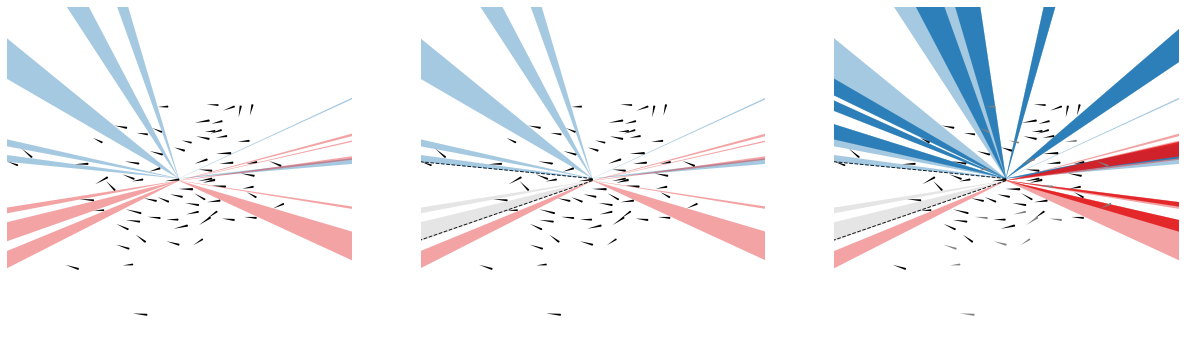

In [64]:
showcase = [[0,2],[1,15],[2,19],[3,65]]  # sets the focal fish for each group size example

scnum=3
indivlinewidth=2
groupsize_pixels = 310
groupsize_pixels = 480
numpoints=1000
blockingprobs=[0.75,0.5]
whichblockingprob_toplot = 0  # 0 = 'high', 1='low'
savedrand=True
for scnum in [2]:  # do a few, and then pick the best random ones to use for illustration
    f,ax=plt.subplots(1,3,sharex=True,sharey=True)
    f.set_size_inches(21,7)       
    case, focal = showcase[scnum]

    fsegs,points,orients,le_rot,re_rot,tail_rot,seen,seen_problow,seen_probhigh,seen_blind = exampledata[case]
    segments = np.reshape(fsegs,(allnumfish[case],-1,2))


    numfish=allnumfish[case]
    numsegperfish = 4
    segids = np.hstack(np.tile(np.arange(numfish),(numsegperfish,1)).T)


    allpoints = detection.getpointpositions_many([0,0],[0,0],dist=1200,numpoints=numpoints)
    segstep = np.reshape(segments,(-1,2,2))
    mask = np.tile(True,len(segstep))
    mask_le = mask.copy()
    mask_re = mask.copy()
    mask_le[focal*4+2:focal*4+4] = False
    mask_re[focal*4:focal*4+2] = False

    randperfish = np.random.rand(numfish)
    # some ones that looked good
    if savedrand:
        if scnum==0:
            randperfish = np.array([0.78044621, 0.49512432, 0.96942171, 0.32303783, 0.93948414, 0.12023997, 0.99577361, 0.72218697, 0.94693339, 0.04703068])
        if scnum==1:
            randperfish = np.array([0.27598298, 0.84736355, 0.73592942, 0.14900942, 0.01337228,
               0.86873182, 0.29884719, 0.39867657, 0.36548399, 0.08032052,
               0.85933155, 0.06058503, 0.24737188, 0.67202587, 0.33248481,
               0.0756488 , 0.98649958, 0.69632245, 0.04549887, 0.72739717,
               0.64924356, 0.79323052, 0.68031495, 0.57611462, 0.07778526,
               0.07721601, 0.97886447, 0.7568259 , 0.05899104, 0.1552364 ])
        if scnum==2:
            randperfish = np.array([0.72680297, 0.06420069, 0.48202541, 0.88374378, 0.19818863,
               0.73909397, 0.56077914, 0.47670229, 0.95080892, 0.84254809,
               0.10251673, 0.13985372, 0.81989923, 0.8408299 , 0.5613557 ,
               0.45779418, 0.47998224, 0.60697844, 0.13026498, 0.26232139,
               0.48395252, 0.77437176, 0.3995704 , 0.143545  , 0.88804021,
               0.59956586, 0.30509829, 0.04720218, 0.1615956 , 0.27960581,
               0.90009235, 0.67724798, 0.42039713, 0.15093324, 0.56534304,
               0.99331939, 0.32627054, 0.05980433, 0.36394278, 0.92525086,
               0.3434561 , 0.76652325, 0.42390302, 0.13552875, 0.698963  ,
               0.20882417, 0.90756976, 0.75952151, 0.80255579, 0.94790934,
               0.69557615, 0.02339454, 0.74246989, 0.29248389, 0.52539355,
               0.45427453, 0.09833606, 0.40027976, 0.18920493, 0.36095319,
               0.49718225, 0.44412529, 0.27719228, 0.99385285, 0.24380521,
               0.35550663, 0.82525668, 0.90766898, 0.94341221, 0.54378749])
        if scnum==3:
            randperfish = np.array([0.25445774, 0.13096152, 0.93604927, 0.74114589, 0.5074656 ,
           0.08820481, 0.59955363, 0.79032887, 0.93788413, 0.98611649,
           0.76873641, 0.74158176, 0.42801741, 0.47655222, 0.86005494,
           0.54136424, 0.28608526, 0.1632767 , 0.19189753, 0.90954676,
           0.24398512, 0.33357238, 0.47094293, 0.41983618, 0.91167147,
           0.86652999, 0.26406125, 0.02756068, 0.79373691, 0.82055229,
           0.0838107 , 0.30616178, 0.92321552, 0.58006165, 0.63686943,
           0.80715934, 0.83722596, 0.26222753, 0.60350373, 0.71032733,
           0.62750767, 0.79254432, 0.25802358, 0.92443726, 0.14117821,
           0.88979414, 0.63346544, 0.86857463, 0.4950825 , 0.45389412,
           0.31507063, 0.27747103, 0.77994563, 0.21713653, 0.00113619,
           0.01309836, 0.82532384, 0.36286099, 0.35804751, 0.3829743 ,
           0.40322687, 0.32465503, 0.24498775, 0.32158282, 0.12920552,
           0.02642868, 0.56461388, 0.2665478 , 0.16039909, 0.20063626,
           0.30026741, 0.45931383, 0.826355  , 0.47194373, 0.99345005,
           0.98871742, 0.19456179, 0.44395634, 0.55221768, 0.58701069,
           0.29608124, 0.74987889, 0.71872723, 0.44115824, 0.00560306,
           0.1943967 , 0.6278557 , 0.04449283, 0.42314383, 0.36738304,
           0.59742988, 0.8279686 , 0.67461933, 0.289037  , 0.69235244,
           0.58644269, 0.69869164, 0.86904564, 0.65895874, 0.80863556,
           0.37122374, 0.4383213 , 0.87167467, 0.88255902, 0.35153607,
           0.21347987, 0.30836223, 0.07903961, 0.39610247, 0.91218648,
           0.71421831, 0.92684695, 0.19528919, 0.34464313, 0.81517561,
           0.23350763, 0.82668096, 0.57345838, 0.35232039, 0.02950266,
           0.44133491, 0.83806467, 0.55660087, 0.72193058, 0.51584106,
           0.11367614, 0.83809058, 0.54402195, 0.8678504 , 0.41277726,
           0.50540502, 0.17927187, 0.86200184, 0.06698147, 0.33381949,
           0.12125418, 0.47752787, 0.43825511, 0.38724405, 0.32869064,
           0.11104268, 0.41363214, 0.83400718, 0.10025869, 0.33968505,
           0.89734661, 0.75870579, 0.03417323, 0.93744552, 0.29804227,
           0.43755203])
    randpersegments = np.hstack(np.tile(randperfish,(numsegperfish,1)).T)
    randvalues = np.tile(randpersegments,(numpoints,1)).T
    randvalues[segids==focal]=0  # the fish's own body always blocks itself

    da = allpoints - le_rot[focal]
    lpointangles = np.arctan2(da[:,1],da[:,0])
    lseen = detection.getoneray_intersecttest(le_rot[focal],segstep[mask_le],lpointangles)
    lseen_high = detection.getoneray_intersecttest_probabilistic(le_rot[focal],segstep[mask_le],lpointangles,randvalues[mask_le],blockingprobs[0])
    lseen_low = detection.getoneray_intersecttest_probabilistic(le_rot[focal],segstep[mask_le],lpointangles,randvalues[mask_le],blockingprobs[1])

    da = allpoints - re_rot[focal]
    rpointangles = np.arctan2(da[:,1],da[:,0])
    rseen = detection.getoneray_intersecttest(re_rot[focal],segstep[mask_re],rpointangles)
    rseen_high = detection.getoneray_intersecttest_probabilistic(re_rot[focal],segstep[mask_re],rpointangles,randvalues[mask_re],blockingprobs[0])    
    rseen_low = detection.getoneray_intersecttest_probabilistic(re_rot[focal],segstep[mask_re],rpointangles,randvalues[mask_re],blockingprobs[1])    

    # set the region of overlap
    lrelangle = detection.fixanglerange(lpointangles-orients[focal])
    lsel = lrelangle<-binocularangle
    lseen[lsel]=0
    lseen_high[lsel]=0          
    lseen_low[lsel]=0

    rrelangle = detection.fixanglerange(rpointangles-orients[focal])
    rsel = rrelangle>binocularangle
    rseen[rsel]=0
    rseen_high[rsel]=0
    rseen_low[rsel]=0

    # for blind spot
    da = allpoints - points[focal]
    pointangles = np.arctan2(da[:,1],da[:,0])
    relangle = detection.fixanglerange(pointangles-orients[focal])
    lseen_blind = lseen.copy()
    rseen_blind = rseen.copy()
    blindsel = np.abs(relangle)>blind_start
    lseen_blind[blindsel] = 0
    rseen_blind[blindsel] = 0
    lseen_high[blindsel] = 0
    rseen_high[blindsel] = 0
    lseen_low[blindsel] = 0
    rseen_low[blindsel] = 0    
    blind_start_point, blind_end_point = allpoints[np.where(np.abs(relangle)>blind_start)[0][[0,-1]]]

       

    alpha=0.4
    a=ax[0]
    plotexternal_fill(a,le_rot[focal],lseen,lpointangles,alphavalue=alpha,color=pairedcolors[0+1],dist=groupsize_pixels*200)
    plotexternal_fill(a,re_rot[focal],rseen,rpointangles,alphavalue=alpha,color=pairedcolors[4+1],dist=groupsize_pixels*200)   
    plotfishsegments(segments,ax=a)
#     a.set_title('Full blockage')
    
    # blind spot
    a=ax[1]
    plotexternal_fill(a,le_rot[focal],lseen_blind,lpointangles,alphavalue=alpha,color=pairedcolors[0+1],dist=groupsize_pixels*200)
    plotexternal_fill(a,re_rot[focal],rseen_blind,rpointangles,alphavalue=alpha,color=pairedcolors[4+1],dist=groupsize_pixels*200)   
    
    plotexternal_fill(a,le_rot[focal],lseen & np.logical_not(lseen_blind),lpointangles,alphavalue=0.5*alpha,color='grey',dist=groupsize_pixels*200)
    plotexternal_fill(a,re_rot[focal],rseen & np.logical_not(rseen_blind),rpointangles,alphavalue=0.5*alpha,color='grey',dist=groupsize_pixels*200) 
    a.plot([le_rot[focal,0],blind_start_point[0]],[le_rot[focal,1],blind_start_point[1]],c='k',linestyle='--',linewidth=1,zorder=-10)
    a.plot([re_rot[focal,0],blind_end_point[0]],[re_rot[focal,1],blind_end_point[1]],c='k',linestyle='--',linewidth=1,zorder=-10)
    plotfishsegments(segments,ax=a)
#     a.set_title('Including blind spot')

    # incomplete blocking and blind splot
    a=ax[2]
    if whichblockingprob_toplot==0:  #"high"
        templ = lseen_high
        tempr = rseen_high
    elif whichblockingprob_toplot==1: # "low"
        templ = lseen_low
        tempr = rseen_low
    plotexternal_fill(a,le_rot[focal],templ,lpointangles,alphavalue=alpha,color=pairedcolors[0+1],dist=groupsize_pixels*200)
    plotexternal_fill(a,re_rot[focal],tempr,rpointangles,alphavalue=alpha,color=pairedcolors[4+1],dist=groupsize_pixels*200)   
    plotexternal_fill(a,le_rot[focal],templ & np.logical_not(lseen_blind),lpointangles,alphavalue=0.9,color=pairedcolors[0+1],dist=groupsize_pixels*200)
    plotexternal_fill(a,re_rot[focal],tempr & np.logical_not(rseen_blind),rpointangles,alphavalue=0.9,color=pairedcolors[4+1],dist=groupsize_pixels*200)   


    plotexternal_fill(a,le_rot[focal],lseen & np.logical_not(lseen_blind),lpointangles,alphavalue=0.5*alpha,color='grey',dist=groupsize_pixels*200)
    plotexternal_fill(a,re_rot[focal],rseen & np.logical_not(rseen_blind),rpointangles,alphavalue=0.5*alpha,color='grey',dist=groupsize_pixels*200) 
    a.plot([le_rot[focal,0],blind_start_point[0]],[le_rot[focal,1],blind_start_point[1]],c='k',linestyle='--',linewidth=1,zorder=-10)
    a.plot([re_rot[focal,0],blind_end_point[0]],[re_rot[focal,1],blind_end_point[1]],c='k',linestyle='--',linewidth=1,zorder=-10)    
#     a.set_title('Probabilistic blockage (blocking prob of '+str(blockingprobs[0]) + ')')
    fishcolors = np.tile('k',numfish).astype('object')
    fishcolors[randperfish>blockingprobs[0]] = 'grey'
    plotfishsegments(segments,ax=a,clrs=fishcolors)
    

    a.set_xlim([-groupsize_pixels+points[focal,0],groupsize_pixels+points[focal,0]])
    a.set_ylim([-groupsize_pixels+points[focal,1],groupsize_pixels+points[focal,1]])
    for a in ax:
#         a.set_rasterized(True)
        a.set_aspect(1.0)
        a.set_axis_off()
        a.set_aspect(1.0)

    print('Num fish ignored:', [np.sum(randperfish>b) for b in blockingprobs])
#     pdf.savefig(f) if savefigures else None   
    #output_path = path + 'image-output/3methods-illustrate.pdf'
    #plt.savefig(output_path,dpi=500)
    plt.show()

## 1D:  External detection round plot

In [65]:
# Create Raycasting result, whole group overlayed, and save the alpha channel to do the overlay
groupsizexy=1200

# get all image arrays to save
all_alphachannel = np.zeros((3,4,3600,3600))

# for k in range(2):  # 0 = full, 1= prob + blind, 2 = blind only
# just do the one I'm going to show
k=1
useblind = True if k>=1 else False
for case in range(4):     
    fsegs,points,orients,le_rot,re_rot,tail_rot,seen,seen_problow,seen_probhigh,seen_blind = exampledata[case]
    orients = rc.fixanglerange(orients)  # need to do this, because if not, then the out of range checks below are wrong
    numfish=allnumfish[case]
    f,ax = plt.subplots(1,1,dpi=300)
    f.set_size_inches(12,12)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,hspace=0,wspace=0)
    segments = np.reshape(fsegs,(numfish,-1,2))
    segstep = np.reshape(segments,(-1,2,2))

    # raycasting    
    for focus in range(numfish):
        # raycasting
        le = le_rot[focus]
        re = re_rot[focus]
        numrays=1000
        rayvalues = 2*np.pi*np.arange(0,numrays)/numrays - np.pi
        ba = (blind_start if useblind else np.pi)
        leftrange = orients[focus] + np.array([-binocularangle,ba])
        rightrange = orients[focus] + np.array([-ba,binocularangle])               

        mask = np.tile(True,len(segstep))
        mask_le = mask.copy()
        mask_re = mask.copy()
        mask_le[focus*4+2:focus*4+4] = False
        mask_re[focus*4:focus*4+2] = False            

        if k==1:
            numsegperfish = 4
            segids = np.hstack(np.tile(np.arange(numfish),(numsegperfish,1)).T)
            randperfish = np.random.rand(numfish)
            randpersegments = np.hstack(np.tile(randperfish,(numsegperfish,1)).T)
            randpersegments[segids==focus]=0  # fish's own body always blocks itself
            ignore = np.where(randpersegments>blockingprobs[0])[0]
        else:
            ignore = []
        leftrays=rc.getrays(le,segstep[mask_le],numrays,ignore=ignore)
        rightrays=rc.getrays(re,segstep[mask_re],numrays,ignore=ignore)
        # instead of passing in rayrange, set them to 'seen', because here i'm plotting anti rays, not rays
        #  this returns wrong values if they rays are out of range.. probably should do another way, but it
        leftoutofrange = np.logical_not(rc.checkrange(leftrange,rayvalues))
        rightoutofrange = np.logical_not(rc.checkrange(rightrange,rayvalues))
        leftrays[leftoutofrange,1] = 1
        rightrays[rightoutofrange,1] = 1

    #     plotrays(le,leftrays,alphavalue=0.1,color=pairedcolors[0])
#             plotrays(re,rightrays,alphavalue=0.5,color=pairedcolors[2])        
        alpha = 0.024 * np.sqrt(151)/np.sqrt(numfish)
#             alpha = 0.2 * np.sqrt(151)/np.sqrt(numfish)
        plotantirays_fill(ax,le,leftrays,alphavalue=alpha,color=pairedcolors[0+1],dist=groupsizexy*200)
        plotantirays_fill(ax,re,rightrays,alphavalue=alpha,color=pairedcolors[0+1],dist=groupsizexy*200)            

    # formatting
    ax.set_xlim([-groupsizexy,groupsizexy])
    ax.set_ylim([-groupsizexy,groupsizexy])        
    # ax.set_title(joined_groupstates[step])
    ax.set_aspect(1.0)
    ax.set_rasterization_zorder(0)
    ax.axis('off')
    ax.margins(0,0,tight=True)


    canvas = FigureCanvas(f)
    width, height = f.get_size_inches() * f.get_dpi()
    canvas.draw()
    # image3 = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(height.astype(int),width.astype(int),3)  # make size [w,h,3]
    # Option 2a: get and Convert to a NumPy array.  this is better because its gets the alpha channel
    s, (width, height) = canvas.print_to_buffer()
    image = np.fromstring(s, np.uint8).reshape((height, width, 4))
    plt.clf()


    alphachannel = image[:,:,3]
    print(k,' case ',case,':  max alpha channel (should be <255):',np.max(alphachannel))

    all_alphachannel[k,case] = alphachannel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


1  case  0 :  max alpha channel (should be <255): 217
1  case  1 :  max alpha channel (should be <255): 205
1  case  2 :  max alpha channel (should be <255): 211
1  case  3 :  max alpha channel (should be <255): 203


<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

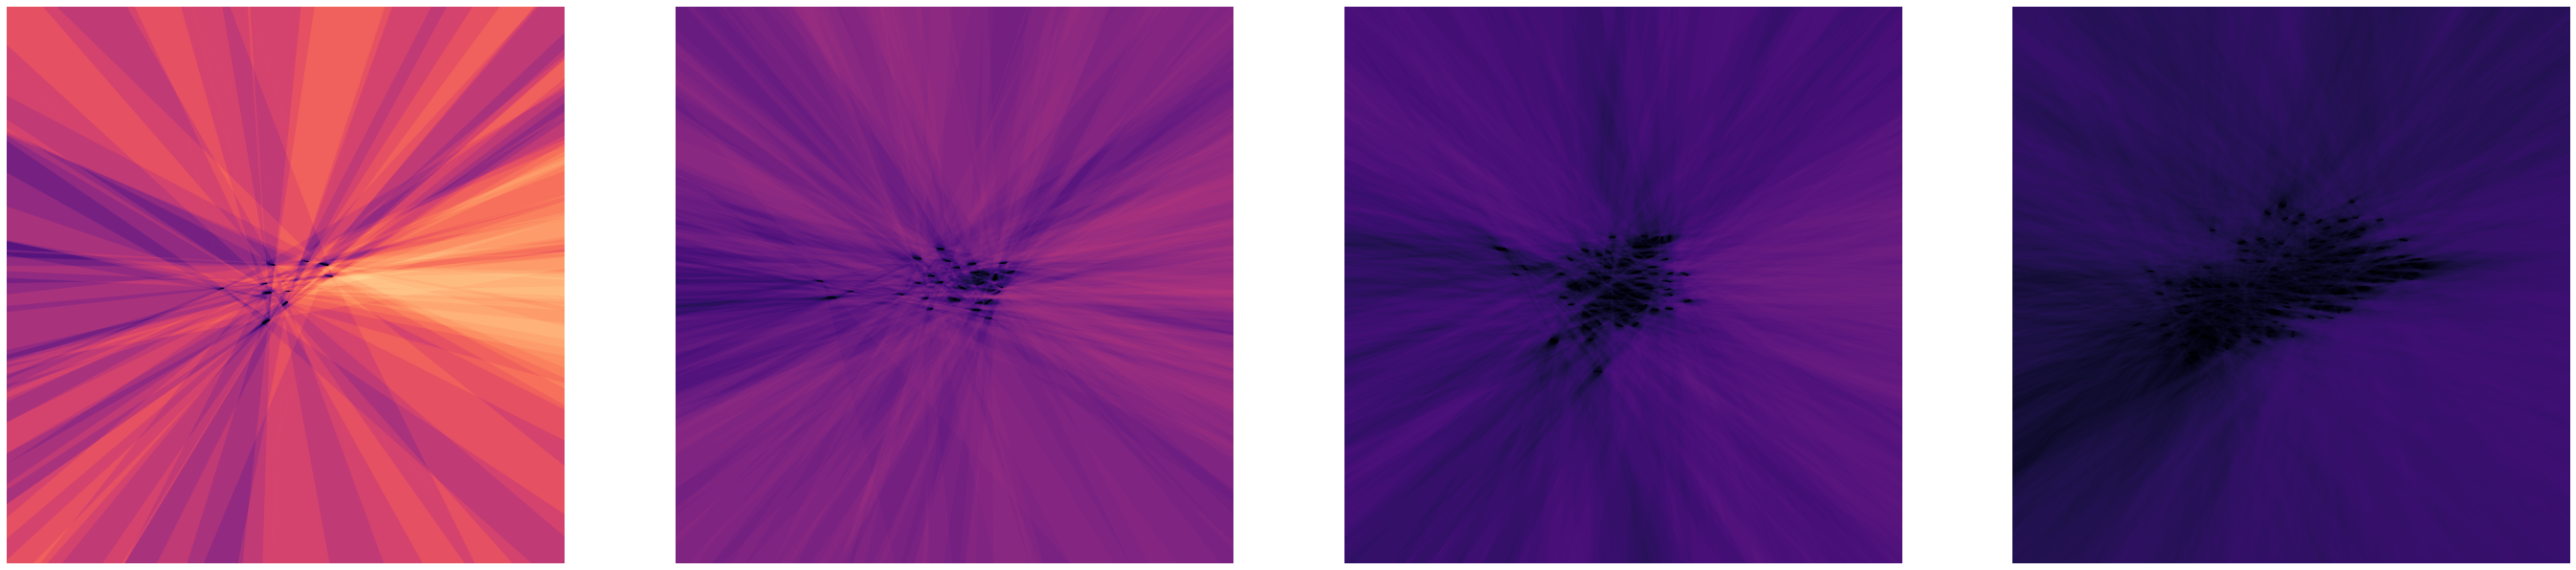

In [67]:
## plot the alpha calculation from previous cell
#savestr = path + 'image-output/groupdetection_N.pdf'
f,ax=plt.subplots(1,4,sharex=True,sharey=True)
f.set_size_inches(12*4,12)
k=1
# for k in range(2):
for case in range(4):
    fsegs,points,orients,le_rot,re_rot,tail_rot,seen,seen_problow,seen_probhigh,seen_blind = exampledata[case]
    numfish=allnumfish[case]
    # plt the alpha results
    a = ax[case]
    a.imshow(all_alphachannel[k,case],extent=(-groupsizexy,groupsizexy,-groupsizexy,groupsizexy),cmap='magma',vmin=0,vmax=0.024 * np.sqrt(151)*np.sqrt(numfish)*255)
    a.set_xlim([-groupsizexy,groupsizexy])
    a.set_ylim([-groupsizexy,groupsizexy])        
    # ax.set_title(joined_groupstates[step])
    a.set_aspect(1.0)
    a.set_rasterization_zorder(0)
    a.axis('off')

    # plot fish bodies as filled in shapes
    segments = np.reshape(fsegs,(allnumfish[case],-1,2))
    plotfishsegments(segments,ax=a)

#plt.savefig(savestr)
plt.show()

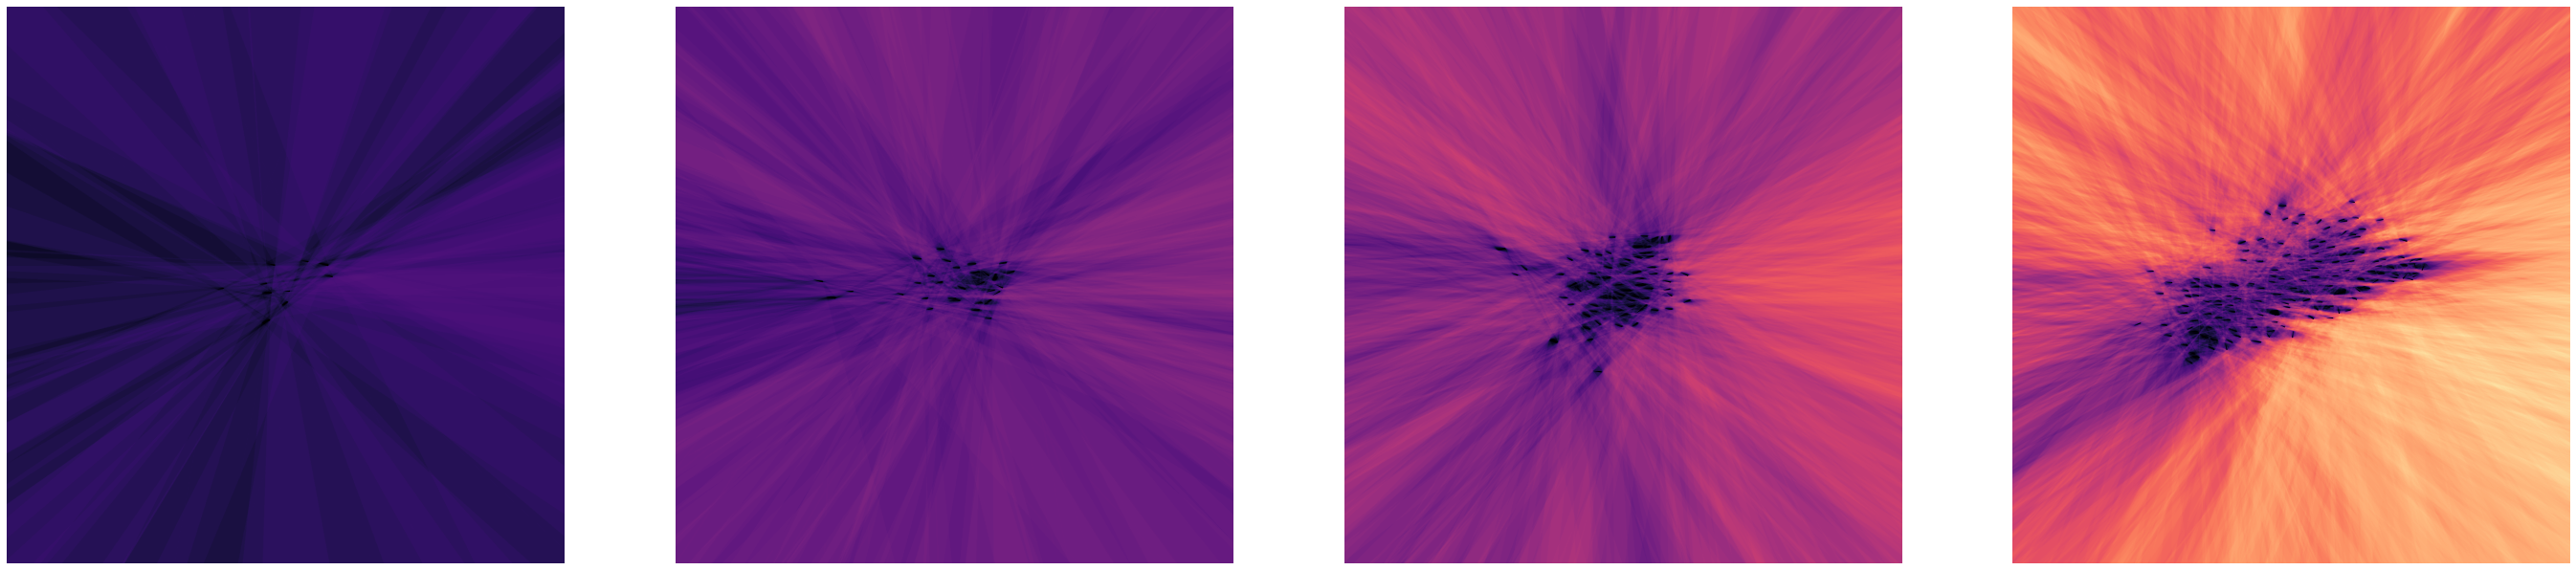

In [68]:
## plot the alpha calculation from previous cell
#savestr = '../image-output/groupdetection_absolute.pdf'

f,ax=plt.subplots(1,4,sharex=True,sharey=True)
f.set_size_inches(12*4,12)
# klabels = ['Full blockage','Incomplete','Blind spot']
k=1

maxN = np.ceil(np.max(all_alphachannel[k,-1])/(0.024*255))
maxN = 35
# for k in range(2):
for case in range(4):
    fsegs,points,orients,le_rot,re_rot,tail_rot,seen,seen_problow,seen_probhigh,seen_blind = exampledata[case]
    numfish=allnumfish[case]
    indivalpha = 0.024*np.sqrt(151)/np.sqrt(numfish)*255
    # plt the alpha results
    a = ax[case]
    a.imshow(all_alphachannel[k,case]/indivalpha,extent=(-groupsizexy,groupsizexy,-groupsizexy,groupsizexy),cmap='magma',vmin=0,vmax=maxN)
    a.set_xlim([-groupsizexy,groupsizexy])
    a.set_ylim([-groupsizexy,groupsizexy])        
    # ax.set_title(joined_groupstates[step])
    a.set_aspect(1.0)
    a.set_rasterization_zorder(0)
    a.axis('off')

    # plot fish bodies as filled in shapes
    segments = np.reshape(fsegs,(allnumfish[case],-1,2))
    plotfishsegments(segments,ax=a)
         
#plt.savefig(savestr)
plt.show()

# (2)  Fig 2:  External detection distributions

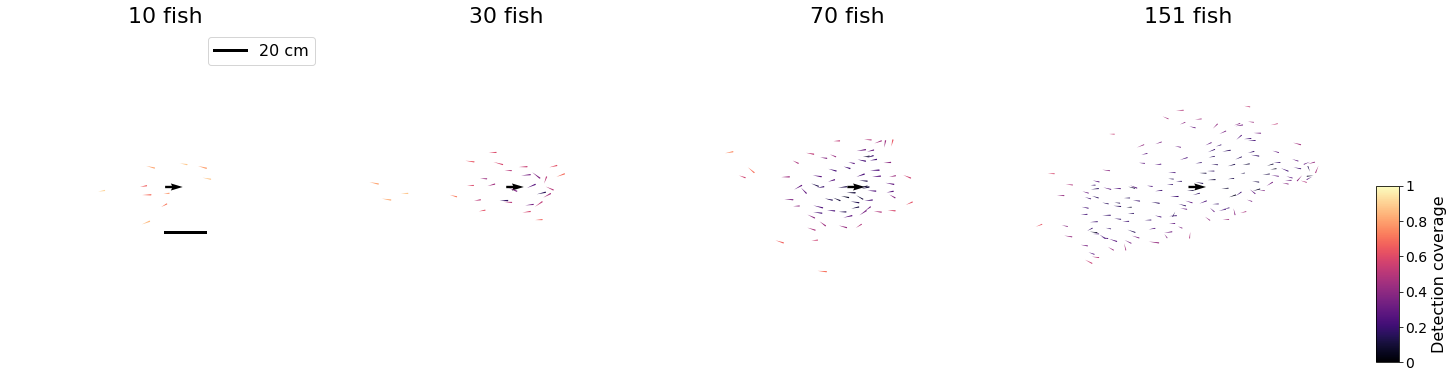

In [70]:
degreevalues = (degreebins[1:]+degreebins[0:-1])/2

f,ax=plt.subplots(1,4,sharey='row',sharex='row')
f.set_size_inches(24,8.6*1.5/2)
plt.subplots_adjust(wspace=0.08,hspace=0.25)  # do this before setting aspect ratio

indivlinewidth=2
groupsize_pixels=700

cmap = plt.get_cmap('magma')  # note that default normalization is 0 to 255, so use this to define colors

for case in range(4):
    fsegs,points,orients,le_rot,re_rot,tail_rot,seen,seen_problow,seen_probhigh,seen_blind = exampledata[case]
    segments = np.reshape(fsegs,(allnumfish[case],-1,2))
    colors = seen
    
    plotfishsegments(segments,ax[case],clrs=cmap(colors))
    
    # plot the group centroid arrow
    ax[case].quiver(0,0,1,0)
    
    

# ax0 formatting
ax[0].set_xlim([-groupsize_pixels,groupsize_pixels])
ax[0].set_ylim([-groupsize_pixels,groupsize_pixels])
[a.set_aspect(1.0) for a in ax]    
[a.set_axis_off() for a in ax]
# make a legend for size in pixels
cmsize = 20
ax[0].plot([0,cmsize/cmperpixel],[-200,-200],'k',linewidth=3,label=str(cmsize)+' cm')
ax[0].legend(fontsize=16)

#legend/colorbar:  magma
a=ax[-1]
position=f.add_axes([a._position.bounds[0]+0.2,a._position.bounds[1]-0,.013,.38])
cbar=plt.colorbar(plt.pcolormesh(np.tile([np.linspace(1,0,100)],(10,1)).T,cmap='magma',vmin=0,vmax=1),ax=a,cax=position,orientation='vertical')    
cbar.set_label('Detection coverage',fontsize=16)
ticks = [0,0.2,0.4,0.6,0.8,1]
cbar.set_ticks(ticks)
ticks=[str(t) for t in ticks]
cbar.set_ticklabels(ticks)
cbar.ax.tick_params(labelsize=14)

# common formatting
[a.set_aspect(1.0) for a in ax]
[a.tick_params(labelsize=14) for a in ax]
[ax[c].set_title(str(allnumfish[c])+' fish',fontsize=22) for c in range(4)]


#pdf.savefig(f) if savefigures else None
#plt.savefig('../image-output/2a-illustration.pdf')
plt.show()

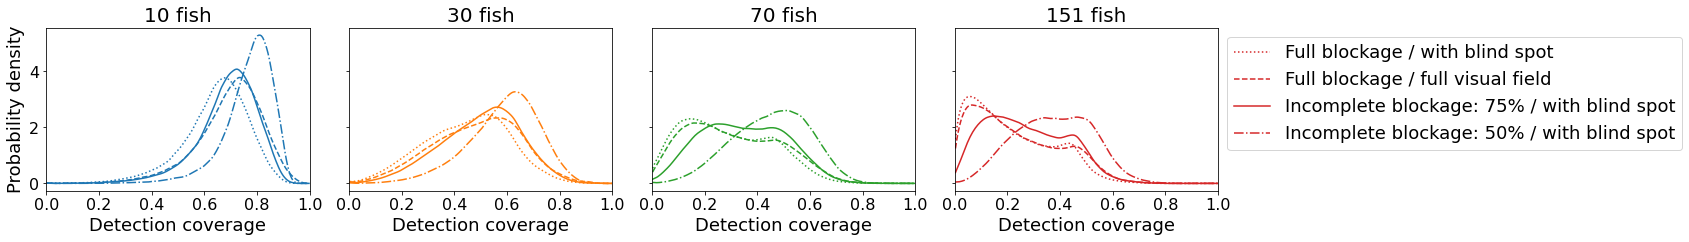

In [71]:
f,ax=plt.subplots(1,4,sharey=True,sharex=True)
f.set_size_inches(21,3)
plt.subplots_adjust(wspace=0.15)  # do this before setting aspect ratio

for case in range(4):
    #  note:  if calculated with "smooth histogram", then set this really low to plot, because its already smoothed 
    a = ax[case]
    a.plot(degreevalues,distributions1D_blind[case],c=snscolors[case],linestyle='dotted',label='Full blockage / with blind spot')    
    a.plot(degreevalues,distributions1D[case],c=snscolors[case],linestyle='--',label='Full blockage / full visual field')
    a.plot(degreevalues,distributions1D_probhigh[case],c=snscolors[case],linestyle='-',label='Incomplete blockage: 75% / with blind spot')
    a.plot(degreevalues,distributions1D_problow[case],c=snscolors[case],linestyle='dashdot',label='Incomplete blockage: 50% / with blind spot')
    a.set_title(str(allnumfish[case])+' fish',fontsize=20)
    
# ax[1] formatting
[a.set_xlabel('Detection coverage',fontsize=18) for a in ax]
ax[0].set_ylabel('Probability density',fontsize=18)
ax[0].set_xlim([0,1])
ax[-1].legend(fontsize=18,bbox_to_anchor=(1,1))

# common formatting
[a.tick_params(labelsize=16) for a in ax]
# for a in ax:
#     a.grid(True)
#     a.minorticks_on()
#     a.grid(True,which='minor',c='grey',alpha=0.15)
# plt.savefig('../image-output/fig2b-probdists.pdf')
#pdf.savefig(f) if savefigures else None 
plt.show()

## "Blind spot" moving average analysis

In [72]:
import numpy as np
def running_mean_uniform_filter1d(x, N):
    return ndif.uniform_filter1d(x, N, mode='constant', origin=-(N//2))[:-(N-1)]

degreebins = np.linspace(0,1,200)
degreevalues = (degreebins[1:]+degreebins[0:-1])/2

# some functions for convenience, define outside loop
def get1dhist(x):
    return np.histogram(np.reshape(np.mean(x,axis=-1),-1),bins=degreebins, density=True)[0]
def getsmooth1dhist(x):
    kde = scipy.stats.gaussian_kde(np.reshape(np.mean(x,axis=-1),-1))
    return kde.evaluate(degreevalues) 

0


NameError: ignored

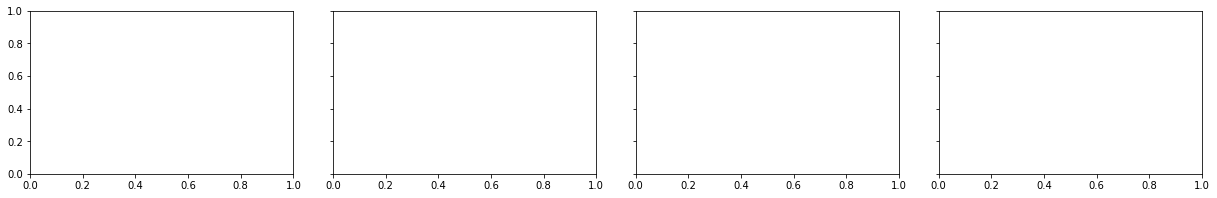

In [74]:
f,ax=plt.subplots(1,4,sharey=True,sharex=True)
f.set_size_inches(21,3)
plt.subplots_adjust(wspace=0.15)  # do this before setting aspect ratio

for case in range(4):
    print(case)
    #  note:  if calculated with "smooth histogram", then set this really low to plot, because its already smoothed 
    a = ax[case]
    a.plot(degreevalues,getsmooth1dhist(grid_allseen[case]),c=snscolors[case],linestyle='--',label='Full visual field')
    a.plot(degreevalues,getsmooth1dhist(grid_allseen_blind[case]),c=snscolors[case],linestyle='dotted',label='Blind angle')        
    ma = 3
    a.plot(degreevalues,getsmooth1dhist(running_mean_uniform_filter1d(grid_allseen_blind[case],ma)>0),c=snscolors[case],linestyle='dashdot',label='Blind angle + 1/3 sec. OR')        
    a.plot(degreevalues,distributions1D_probhigh[case],c=snscolors[case],linestyle='-',label='Blind angle + incomplete blockage')    
#     ma = 5
#     a.plot(degreevalues,getsmooth1dhist(running_mean_uniform_filter1d(grid_allseen_blind[case],ma)>0),c=snscolors[case],linestyle='dashdot',label='Blind spot - ma5')            
    a.set_title(str(allnumfish[case])+' fish',fontsize=20)
    
# ax[1] formatting
[a.set_xlabel('Detection coverage',fontsize=18) for a in ax]
ax[0].set_ylabel('Probability density',fontsize=18)
ax[0].set_xlim([0,1])
ax[-1].legend(fontsize=18,bbox_to_anchor=(1,1))

# common formatting
[a.tick_params(labelsize=16) for a in ax]
# for a in ax:
#     a.grid(True)
#     a.minorticks_on()
#     a.grid(True,which='minor',c='grey',alpha=0.15)
# plt.savefig('../image-output/fig2b-probdists.pdf')
#plt.savefig('../image-output/detectioncoverage.pdf')
#pdf.savefig(f) if savefigures else None 
plt.show()

## Individual detection - distributions

In [ ]:
trial_dlens = [g[::processing_skipvalue].shape[0] for g in grid_frontbackdist]

In [ ]:
indivdetect = [np.mean(x,axis=-1) for x in grid_allseen_probhigh]
indivdetect_pertrial = []
for case in range(4):
    caseinds = np.cumsum(trial_dlens[case*3:(case+1)*3])
    caseinds = np.insert(caseinds,0,0)
    for i in range(len(caseinds)-1):
        indivdetect_pertrial.append(indivdetect[case][caseinds[i]:caseinds[i+1]])
# individual means - per trial
indivmeans_pertrial = [np.mean(i,axis=0) for i in indivdetect_pertrial]
indivstds_pertrial = [np.std(i,axis=0) for i in indivdetect_pertrial]
indivvars_pertrial = [np.var(i,axis=0) for i in indivdetect_pertrial]
# individual means - group by case
indivmeans = [np.concatenate(indivmeans_pertrial[case*3:(case+1)*3]) for case in range(4)]
indivstds = [np.concatenate(indivstds_pertrial[case*3:(case+1)*3]) for case in range(4)]
indivvars = [np.concatenate(indivvars_pertrial[case*3:(case+1)*3]) for case in range(4)]

In [ ]:

# overall mean
mean_toplot = np.array([np.mean(i) for i in indivdetect])
std_toplot = np.array([np.std(i) for i in indivdetect])

f,ax = plt.subplots(1,1,sharex=True)
f.set_size_inches(7,4)
a = ax
for case in range(4):
    nf = allnumfish[case]*(3 if case<3 else 1)
    xwidth = nf/225
    xval = case
    a.errorbar(xval,mean_toplot[case],yerr = std_toplot[case],capsize=xwidth/4*200,color=snscolors[case],fmt='o',linestyle='')
    xrand = xval + np.linspace(-0.5,0.5,nf)*xwidth    # better to do linear space
    tporder = np.random.permutation(np.arange(nf))
    xrand = xrand[tporder]
    a.scatter(xrand,indivmeans[case],color=snscolors[case],s=1,alpha=0.8)
    a.errorbar(xrand,indivmeans[case],yerr = indivstds[case],capsize=0,color=snscolors[case],fmt='',linestyle='',alpha=0.2)
    # "Individual"
    xline = xval - np.array([-xwidth,xwidth])/2*1.06
    a.plot(xline, np.tile(mean_toplot[case]+np.std(indivmeans[case]),2),color=snscolors[case],linestyle='--',zorder=1,linewidth=1.3)
    a.plot(xline, np.tile(mean_toplot[case]-np.std(indivmeans[case]),2),color=snscolors[case],linestyle='--',zorder=1,linewidth=1.3)
    # "Time"
    a.plot(xline, np.tile(mean_toplot[case]+np.sqrt(np.mean(indivvars[case])),2),color=snscolors[case],linestyle=':',zorder=1,linewidth=1.3)
    a.plot(xline, np.tile(mean_toplot[case]-np.sqrt(np.mean(indivvars[case])),2),color=snscolors[case],linestyle=':',zorder=1,linewidth=1.3)    
    
a.set_ylim([0,1])
a.set_xlabel('Number in group',fontsize=18)
a.set_xticks([0,1,2,3])
a.set_xticklabels(allnumfish)
a.tick_params(labelsize=16)

ax.set_ylabel('Individual detection\ncoverage',fontsize=18)
[ax.axvline(x,color='grey',linestyle='-',linewidth=1) for x in [0.5,1.5,2.5]]
ax.set_xlim([-0.5,3.5])
#plt.savefig('../image-output/indiv.pdf')
#pdf.savefig(f) if savefigures else None
plt.show()

In [ ]:
# percentage variance from individual differences versus differences over time
var_all = np.array([np.var(i) for i in indivdetect])
var_time = np.array([np.mean(i) for i in indivvars])
var_indiv = np.array([np.var(i) for i in indivmeans])
print('Changes over time var frac:', var_time/var_all)
print('Individual differences var frac:', var_indiv/var_all)

In [ ]:
pdf.close() if savefigures else None

# (3) Group detection - state dependence

## Number in group that can detect

### Color saturation
INSTEAD OF THIS, BLEND WITH GRAY, WHICH CAN DO BY SIMPLE WEIGHTED AVERAGE

In [ ]:
mean_toplot = np.array([np.mean(np.mean(x,axis=-1)) for x in grid_allseen_probhigh])
std_toplot = np.array([np.std(np.mean(x,axis=-1)) for x in grid_allseen_probhigh])
groupdetect = [np.sum(x,axis=1) for x in grid_allseen_probhigh]
meannum = np.array([np.mean(x) for x in groupdetect])
stdnum = np.array([np.std(x) for x in groupdetect])

grid_groupstatesjoined=[catcasedata(grid_groupstates,case) for case in range(4)]
groupstatenames = ['Polarized','Milling','Swarm','-other']
frac_in_state = np.array([[np.mean(gs==n) for n in groupstatenames] for gs in grid_groupstatesjoined])

f,ax = plt.subplots(1,1,sharex=True)
f.set_size_inches(5,4)
a = ax
for case in range(4):
    spacing = 0.2
    xoffset = spacing*2
    xval = case
    c1 = np.array(snscolors[case])
    c2 = np.tile(0.82,3)
    a.errorbar(xval-xoffset,meannum[case], yerr = stdnum[case],capsize=5,color=c1,fmt='o',linestyle='',markersize=8,label=('All states' if case==3 else None))
    for j, gs in enumerate(groupstatenames):
        vals = groupdetect[case][grid_groupstatesjoined[case]==gs]
        possiblemarkers = ['v', 'x', 'd', '*', 'h', 'H', 'D', 'd', 'P', 'X']
        frac = frac_in_state[case,j]
        c = (frac*c1+(1-frac)*c2)
        a.errorbar(xval+(j+1)*spacing-xoffset, np.mean(vals), yerr=np.std(vals),
                   capsize=3,color=c,fmt=possiblemarkers[j],alpha=1,markersize=8,label=(gs if case==3 else None))

    
a.set_ylim([0,57])
a.set_xlabel('Number in group',fontsize=18)
a.set_xticks([0,1,2,3])
a.set_xticklabels(allnumfish)
a.tick_params(labelsize=16)

[ax.axvline(x,color='grey',linestyle='-',linewidth=1) for x in [0.5,1.5,2.5]]
ax.set_xlim([-0.5,3.5])
a.set_ylabel('Number of detections\nin the group',fontsize=18)
a.legend(fontsize=16)

#pdf.savefig(f) if savefigures else None
#plt.savefig('../image-output/group-state.pdf')
plt.show()

### Transparency

In [ ]:
mean_toplot = np.array([np.mean(np.mean(x,axis=-1)) for x in grid_allseen_probhigh])
std_toplot = np.array([np.std(np.mean(x,axis=-1)) for x in grid_allseen_probhigh])
groupdetect = [np.sum(x,axis=1) for x in grid_allseen_probhigh]
meannum = np.array([np.mean(x) for x in groupdetect])
stdnum = np.array([np.std(x) for x in groupdetect])

grid_groupstatesjoined=[catcasedata(grid_groupstates,case) for case in range(4)]
groupstatenames = ['Polarized','Milling','Swarm','-other']
frac_in_state = np.array([[np.mean(gs==n) for n in groupstatenames] for gs in grid_groupstatesjoined])

f,ax = plt.subplots(1,1,sharex=True)
f.set_size_inches(5,4)
a = ax
for case in range(4):
    spacing = 0.2
    xoffset = spacing*2
    xval = case
    a.errorbar(xval-xoffset,meannum[case], yerr = stdnum[case],capsize=5,color=snscolors[case],fmt='o',linestyle='',markersize=8,label=('All states' if case==3 else None))
    for j, gs in enumerate(groupstatenames):
        vals = groupdetect[case][grid_groupstatesjoined[case]==gs]
        possiblemarkers = ['v', 'x', 'd', '*', 'h', 'H', 'D', 'd', 'P', 'X']
        a.errorbar(xval+(j+1)*spacing-xoffset, np.mean(vals), yerr=np.std(vals),
                   capsize=3,color=snscolors[case],fmt=possiblemarkers[j],alpha=frac_in_state[case,j],markersize=8,label=(gs if case==3 else None))

    
a.set_ylim([0,57])
a.set_xlabel('Number in group',fontsize=18)
a.set_xticks([0,1,2,3])
a.set_xticklabels(allnumfish)
a.tick_params(labelsize=16)

[ax.axvline(x,color='grey',linestyle='-',linewidth=1) for x in [0.5,1.5,2.5]]
ax.set_xlim([-0.5,3.5])
a.set_ylabel('Number of detections\nin the group',fontsize=18)
a.legend(fontsize=16)

pdf.savefig(f) if savefigures else None
plt.savefig('../image-output/group-state.pdf')
plt.show()

In [ ]:
from matplotlib import path 
f,ax=plt.subplots(1,3,sharey='row',sharex='row')
f.set_size_inches(6*len(ax),8.6*1.5/2)
# f.set_size_inches(24*2,8.6*1.5/2*2)
plt.subplots_adjust(wspace=0.08,hspace=0.25)  # do this before setting aspect ratio
# [ for a in ax]    

case=2
gsize_toplot = 400


areaskip = 1
ssjoined=catcasedata(grid_sidesidedist,case,skip=areaskip)
fbjoined=catcasedata(grid_frontbackdist,case,skip=areaskip)
groupstatesjoined=catcasedata(grid_groupstates,case,skip=areaskip)
groupheadingjoined = catcasedata(grid_groupheading,case,skip=areaskip)
gcjoined = catcasedata(grid_groupcentroid,case,skip=areaskip)
numsteps = ssjoined.shape[0]
numfish = ssjoined.shape[1]

distance = np.sqrt(fbjoined**2+ssjoined**2)

steps = [39,18250,7940]
for j, step in enumerate(steps):
    a = ax[j]
    orients = catcasedata(grid_orientations,case,skip=areaskip)[step,:]
    # need to rotate around the group heading axis
    xrot = np.cos(groupheadingjoined[step])
    yrot = -np.sin(groupheadingjoined[step])
    rotatefn = lambda x:  np.dot([[xrot,-yrot],[yrot,xrot]],(x-gcjoined[step]).T).T
    le_rot = rotatefn(catcasedata(grid_lefteye,case,skip=areaskip)[step])
    re_rot = rotatefn(catcasedata(grid_righteye,case,skip=areaskip)[step])
    tail_rot = rotatefn(catcasedata(grid_tailcoords,case,skip=areaskip)[step])
    points = rotatefn(catcasedata(grid_positions,case,skip=areaskip)[step])
    fsegs = detection.fishmodel(points,le_rot,re_rot,tail_rot)    
    plotfishsegments(np.reshape(fsegs,(allnumfish[case],-1,2)),a)
    a.set_aspect(1.0)
    a.set_xlim([-gsize_toplot,gsize_toplot])
    a.set_ylim([-gsize_toplot,gsize_toplot])    

    a.set_xticks([])
    a.set_yticks([])
#pdf.savefig(f) if savefigures else None
plt.show()    

# (4) Direction-dependence of detection

In [ ]:
f, ax2 = plt.subplots(1,4,sharex=True,sharey=True)
f.set_size_inches(12,3)
plt.subplots_adjust(wspace=0.12)

use_robust = True

for case in range(4):
    groupstatesjoined=catcasedata(grid_groupstates,case)
    numpoints = grid_allseen[case].shape[-1]
    
    numfish = allnumfish[case]
    sel = (groupstatesjoined == 'Polarized')
    angles = np.linspace(0,2*np.pi,numpoints+1)[0:-1]

    if use_robust:
        # get Voronoi networks for the points, and then recalculate all_seen
        all_Aij = [detection.getvoronai(np.array([f,s]).T) for f,s in zip(catcasedata(grid_frontbackdist,case)[sel],catcasedata(grid_sidesidedist,case)[sel])]
        getgs = lambda x: np.array([(np.dot(Aij,s) >= np.sum(Aij,axis=0)[:,np.newaxis]/2 ) *s for Aij,s in zip(all_Aij,x)])
        gs = getgs(grid_allseen[case][sel])
        gs_problow = getgs(grid_allseen_problow[case][sel])
        gs_probhigh = getgs(grid_allseen_probhigh[case][sel])
        gs_blind = getgs(grid_allseen_blind[case][sel])
    else:
        gs = grid_allseen[case][sel]
        gs_problow = grid_allseen_problow[case][sel]
        gs_probhigh = grid_allseen_probhigh[case][sel]
        gs_blind = grid_allseen_blind[case][sel]
    
    # detection:  all together
    outervisibility = np.mean(gs,axis=1)
    ytp = np.mean(outervisibility,axis=0)
    
    # detection:  probabilistic
    outervisibility_problow = np.mean(gs_problow,axis=1)
    ytp_problow = np.mean(outervisibility_problow,axis=0)    
    outervisibility_probhigh = np.mean(gs_probhigh,axis=1)
    ytp_probhigh = np.mean(outervisibility_probhigh,axis=0)        
    
    # detection:  blind plot
    outervisibility_blind = np.mean(gs_blind,axis=1)
    ytp_blind = np.mean(outervisibility_blind,axis=0)                

    # make an averaging function, that considers angular symmetry
    tpx = np.arctan2(np.sin(angles),np.cos(angles))
    order = np.argsort(tpx)
    def getmean(tp):
        temp = np.zeros(100)
        temp[0] = tp[100]
        temp[1:100] = (np.flipud(np.abs(tp[1:100])) + tp[101:])/2 
        return temp
    
    #plot
    a=ax2[case]
    tpx_avg = getmean(tpx[order])    
    a.plot(tpx_avg,getmean(ytp[order]),c=snscolors[case],label='Full blockage')    
    a.plot(tpx_avg,getmean(ytp_probhigh[order]),c=snscolors[case],linestyle='--',label='Incomplete blockage: 75%')
    a.plot(tpx_avg,getmean(ytp_problow[order]),c=snscolors[case],linestyle='dotted',label='Incomplete blockage: 50%')
    a.plot(tpx_avg,getmean(ytp_blind[order]),c=snscolors[case],linestyle='dashdot',label='Including blind spot')
    a.set_title(str(allnumfish[case])+' fish',fontsize=18)
#     a.axhline(1,c='k',linewidth=0.8)
    
    
a=ax2[0]
a.set_xlim([0,np.pi])
a.set_ylim([0,1])
a.set_ylabel('Detection probability',fontsize=18)
for a in ax2:
    a.set_xticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
    a.set_xticklabels(['$0$','','$\pi/2$','','$\pi$'])
    a.tick_params(labelsize=16)
    a.set_xlabel('Angle to heading',fontsize=18)

ax2[-1].legend(fontsize=18,bbox_to_anchor=(1,1))

#pdf.savefig(f) if savefigures else None
plt.show()

## Number of individuals that can detect a certain point

In [ ]:
f, ax2 = plt.subplots(1,4,sharex=True,sharey=True)
f.set_size_inches(21,5)
plt.subplots_adjust(wspace=0.12)

for case in range(4):
    groupstatesjoined=catcasedata(grid_groupstates,case)
    numpoints = grid_allseen[case].shape[-1]

    numfish = allnumfish[case]
    sel = (groupstatesjoined == 'Polarized')
    angles = np.linspace(0,2*np.pi,numpoints+1)[0:-1]

    gs = grid_allseen[case][sel]
    gs_problow = grid_allseen_problow[case][sel]
    gs_probhigh = grid_allseen_probhigh[case][sel]
    gs_blind = grid_allseen_blind[case][sel]

    outervisibility = np.sum(gs,axis=1)
    ytp = np.mean(outervisibility,axis=0)
    ytp_std = np.std(outervisibility,axis=0)

    # detection:  probabilistic
    outervisibility_problow = np.sum(gs_problow,axis=1)
    ytp_problow = np.mean(outervisibility_problow,axis=0)    
    ytp_problow_std = np.std(outervisibility_problow,axis=0)    
    outervisibility_probhigh = np.sum(gs_probhigh,axis=1)
    ytp_probhigh = np.mean(outervisibility_probhigh,axis=0)        
    ytp_probhigh_std = np.std(outervisibility_probhigh,axis=0)   

    # detection:  blind plot
    outervisibility_blind = np.sum(gs_blind,axis=1)
    ytp_blind = np.mean(outervisibility_blind,axis=0)   
    ytp_blind_std = np.std(outervisibility_blind,axis=0)   

    # make an averaging function, that considers angular symmetry
    tpx = np.arctan2(np.sin(angles),np.cos(angles))
    order = np.argsort(tpx)
    def getmean(tp):
        temp = np.zeros(100)
        temp[0] = tp[100]
        temp[1:100] = (np.flipud(np.abs(tp[1:100])) + tp[101:])/2 
        return temp


    #plot
    a=ax2[case]
    a = plt.subplot(1,4,case+1,projection='polar')
    
    tpx_avg = getmean(tpx[order])    
    tpx_joined = np.concatenate((tpx_avg,2*np.pi - np.flip(tpx_avg)))
    def joiny(x):
        temp = getmean(x[order])
        return np.concatenate((temp,np.flip(temp)))
    
    a.plot(tpx_joined,joiny(ytp),c=snscolors[case],linestyle='--',label='Full blockage')    
    a.plot(tpx_joined,joiny(ytp_probhigh),c=snscolors[case],linestyle='-',label='Incomplete blockage: 75%')
    a.fill_between(tpx_joined,joiny(ytp_probhigh+ytp_probhigh_std),joiny(ytp_probhigh-ytp_probhigh_std),color=snscolors[case],alpha=0.5)    
    a.plot(tpx_joined,joiny(ytp_problow),c=snscolors[case],linestyle='dashdot',label='Incomplete blockage: 50%')
    a.plot(tpx_joined,joiny(ytp_blind),c=snscolors[case],linestyle='dotted',label='Including blind spot')
    a.set_title(str(allnumfish[case])+' fish',fontsize=18)
#     a.set_xticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
    a.set_yticks([10,30,50,70])
#     a.set_xticklabels(['$0$','','$\pi/2$','','$\pi$'])
    a.tick_params(labelsize=16)
    a.set_xlabel('Angle to group heading',fontsize=18)
    a.set_ylim([0,75])    

a=ax2[0]
a.set_xlim([0,np.pi])
a.set_ylabel('Number of individuals that detect the point',fontsize=18)
# for a in ax2:

# ax2[-1].legend(fontsize=18,bbox_to_anchor=(1,1))
plt.subplots_adjust(wspace=0.25)
#plt.savefig('../image-output/angular-round.pdf')
#pdf.savefig(f) if savefigures else None
plt.show()

## View all individuals in the group which can see the point.


In [ ]:
# use the same configuration as from figure 1 to make illustration.
# this is already centered and rotated to the coordinate frame of the group direction of travel

In [ ]:
# View all individuals in the group which can see the point.
# NOTE:  use 'positions', instead of front-back or left-right, because I didn't transform the midcoords to the group heading

case = 2
groupsizexy=1210
numpoints=4   # don't change this - want to be at certain angles
pointdist = 1200
alphaval=0.2

fsegs,points,orients,le_rot,re_rot,tail_rot,seen,seen_problow,seen_probhigh,seen_blind = exampledata[case]
segments = np.reshape(fsegs,(allnumfish[case],-1,2))
segstep = np.reshape(segments,(-1,2,2))

f,ax = plt.subplots(1,1)
f.set_size_inches(12,12)
# f.set_size_inches(30,30)


# get angle to the detection.

alldetectionpoints = detection.getpointpositions_many([0,0],[0,0],dist=pointdist,numpoints=numpoints)       
for whichpoint in [0,1]:
    raycolor=pairedcolors[3] if whichpoint==0 else pairedcolors[7]
    raycolor = snscolors[[5,7][whichpoint]]
    detectionpoint = alldetectionpoints[whichpoint]

    for focus in range(allnumfish[case]):
        mask = np.tile(True,len(segstep))
        mask_le = mask.copy()
        mask_re = mask.copy()
        mask_le[focus*4+2:focus*4+4] = False
        mask_re[focus*4:focus*4+2] = False    
        
        le, re = le_rot[focus], re_rot[focus]
        da = np.array([detectionpoint]) - le
        lpointangles = np.arctan2(da[:,1],da[:,0])
        lseen = detection.getoneray_intersecttest(le,segstep[mask_le],lpointangles)[0]
        
        da = np.array([detectionpoint]) - re
        rpointangles = np.arctan2(da[:,1],da[:,0])
        rseen = detection.getoneray_intersecttest(re,segstep[mask_re],rpointangles)[0]     
        
        if lseen:
            ax.plot([le[0],detectionpoint[0]],[le[1],detectionpoint[1]],c=raycolor,alpha=alphaval)
        if rseen:
            ax.plot([re[0],detectionpoint[0]],[re[1],detectionpoint[1]],c=raycolor,alpha=alphaval)
            
    ax.scatter(detectionpoint[0],detectionpoint[1],c='k',s=80,zorder=20)
    print(np.round(detectionpoint))

plotfishsegments(segments,ax)


ax.arrow(0,0,20,0,  color='k', head_width=20)    

ax.set_xlim([-groupsizexy,groupsizexy])
ax.set_ylim([-groupsizexy,groupsizexy])        
ax.set_aspect(1.0)
ax.set_rasterization_zorder(0)


# for scale legend
cmsize = 20
plt.plot([0,cmsize/cmperpixel],[-1000,-1000],'k',linewidth=3,label=str(cmsize)+' cm')
plt.legend(fontsize=16)
plt.axis('off')
#pdf.savefig(f) if savefigures else None
plt.show()

## Individual detection vs position in group 

In [ ]:
## Loop through and save the calculations needed in order to make the plot


distbins_fs = np.linspace(0,1000,120) 

use_robust = True

# for results_to_plot,title in zip ([grid_allseen,grid_allseen_probhigh,grid_allseen_blind],
#                                           ['Complete blockage','Probabilistic blockage: 75%','Incuding blind spot']
#                                           ):

results_to_plot = grid_allseen_probhigh
title = 'Probabilistic blockage: 75%'

f,ax=plt.subplots(1,2,sharey=True,sharex=True)
f.set_size_inches(10,4)

for case in range(4):
    groupstatesjoined=catcasedata(grid_groupstates,case)
    sel = (groupstatesjoined == 'Polarized')
    ssjoined=catcasedata(grid_sidesidedist,case)[sel]  # already select for only the polarized state
    fbjoined=catcasedata(grid_frontbackdist,case)[sel]    
    numfish = ssjoined.shape[1]    

    if use_robust:
        rp = results_to_plot[case][sel].copy()
        all_Aij = [detection.getvoronai(np.array([f,s]).T) for f,s in zip(fbjoined,ssjoined)]
        getgs = lambda x: np.array([(np.dot(Aij,s)>=1)*s for Aij,s in zip(all_Aij,x)])
        rp = getgs(results_to_plot[case][sel])            
    else:
        rp = results_to_plot[case][sel]

    averagedetectionnorm=1
#     averagedetectionnorm = (1)/np.mean(rp)    
    gethistdata = lambda x: np.reshape(x,-1)*averagedetectionnorm

    fbx = np.reshape(np.tile(np.max(fbjoined,axis=1),(numfish,1)).T - fbjoined,-1)
    fbdetect = scipy.stats.binned_statistic(fbx,gethistdata(rp[:,:,0]),'mean', bins=distbins_fs)[0]
    fbcounts = scipy.stats.binned_statistic(fbx,gethistdata(rp[:,:,0]),'count', bins=distbins_fs)[0]
    fbcounts = fbcounts/np.sum(fbcounts)
    fbcounts = fbcounts/np.max(np.sort(fbcounts)[:-1])  # do this because the first one by definition always is the highest, so its weird for the small groups

    ssx = np.reshape(np.tile(np.max(ssjoined,axis=1),(numfish,1)).T - ssjoined,-1)
    ssdetect = scipy.stats.binned_statistic(ssx,gethistdata(rp[:,:,24]),'mean', bins=distbins_fs)[0]
    sscounts = scipy.stats.binned_statistic(ssx,gethistdata(rp[:,:,24]),'count', bins=distbins_fs)[0]
    sscounts = sscounts/np.sum(sscounts)
    sscounts = sscounts/np.max(np.sort(sscounts)[:-1])

    xtp = (distbins_fs[0:-1]+distbins_fs[1:])/2 * cmperpixel
    for j in range(len(xtp)):
        ax[0].scatter(xtp[j],fbdetect[j],c=[snscolors[case]],alpha=np.minimum(fbcounts[j],1),s=25)
        ax[1].scatter(xtp[j],ssdetect[j],c=[snscolors[case]],alpha=np.minimum(sscounts[j],1),s=25)

ax[0].set_xlim([0,105])
ax[0].set_ylim([0,1])
ax[0].set_ylabel('Average detection probability',fontsize=18)
ax[0].set_xlabel('Distance from front edge (cm)',fontsize=18)
ax[1].set_xlabel('Distance from side edge (cm)',fontsize=18)
ax[0].set_title('Object at front',fontsize=18)
ax[1].set_title('Object at side',fontsize=18)
[a.tick_params(labelsize=16) for a in ax]
plt.subplots_adjust(wspace=0.05)
plt.suptitle(title,fontsize=20,y=1.05)
#pdf.savefig(f) if savefigures else None
plt.show()

# (3.5) Area of the group and individual area within the group

In [ ]:
keepfrac = 1  # fraction of the fish closest to the center of the group to use for the area calculation
area_conv = cmperpixel**2 # (cm/pixel)^2

from matplotlib import path 
def getareas(whichskip):
    allarea = []
    allhistcalc = []
    all_indivareas = []

    for case in range(4):
        print(case)
        if whichskip==0:
            areaskip = processing_skipvalue
        else:
            areaskip = 1 if case==0 else 3
    #     areaskip = 6 if case==0 else 10
        ssjoined=catcasedata(grid_sidesidedist,case,skip=areaskip)
        fbjoined=catcasedata(grid_frontbackdist,case,skip=areaskip)
        groupstatesjoined=catcasedata(grid_groupstates,case,skip=areaskip)
        numsteps = ssjoined.shape[0]
        numfish = ssjoined.shape[1]

        distance = np.sqrt(fbjoined**2+ssjoined**2)

        numkeep = np.ceil(keepfrac*numfish).astype(int)
        srtorder = np.argsort(distance,axis=1)
        doselection=True
        if doselection:
            allsel = np.tile(False,distance.shape)
            for step in range(numsteps):
                allsel[step,srtorder[step,0:numkeep]]=True
        else:
            allsel = np.tile(True,distance.shape)

        area = np.zeros(numsteps)
        indiv_areas = []  # only keep individual areas that are within the outside boundary.  So, add to a list
        for step in range(0,numsteps):
            if np.mod(step,20000)==0:
                print(step,numsteps)
            points = np.array([fbjoined[step,allsel[step]],ssjoined[step,allsel[step]]]).T
            hull = scipy.spatial.ConvexHull(points)
            area[step] = hull.volume  # area= perimenter in 2D... get "volume"  (https://stackoverflow.com/questions/19873596/convex-hull-area-in-python)

            vor = scipy.spatial.Voronoi(points)
            p = path.Path(points[hull.vertices])  
            for region in vor.regions:   
                if (not -1 in region) and (len(region)>0):
                    polygon = vor.vertices[region]
                    if np.all(p.contains_points(polygon)):
                        indiv_areas.append(scipy.spatial.ConvexHull(polygon).volume)        

        histcalc = np.histogram(area/keepfrac,bins=50)
        allarea.append(area)
        allhistcalc.append(histcalc)
        all_indivareas.append(indiv_areas)

    return allarea, allhistcalc, all_indivareas

## Detection and area of the group

In [ ]:
allarea, allhistcalc, all_indivareas = getareas(0)

In [ ]:
def plotalphaline(x,y,c,alphavals,ax='',zorder=-1,linewidth=1,dxfrac=1,skip=1):
    if ax=='':
        f,ax = plt.subplots(1,1)
    for k in range(0,len(x)-skip,skip):
        dx = x[k+skip]-x[k]
        dy = y[k+skip]-y[k]
        space = dxfrac*dx
        yspace = dxfrac*dy
        if yspace>space:
            dxfrac = space/dy
        ax.plot([x[k],x[k]+dxfrac*dx],[y[k],y[k]+dxfrac*dy],c=c,alpha=np.mean(alphavals[k:k+1+skip]),zorder=zorder,linewidth=linewidth,rasterized=True)
        
def plotalphafill(x,y1,y2,c,alphavals,ax='',zorder=-1,dxfrac=1,skip=1):
    if ax=='':
        f,ax = plt.subplots(1,1)
    for k in range(0,len(x)-skip,skip):
        dx = x[k+skip]-x[k]
        dy1 = y1[k+skip]-y1[k]
        dy2 = y2[k+skip]-y2[k]        
        ax.fill_between([x[k],x[k]+dxfrac*dx],[y1[k],y1[k]+dxfrac*dy1],[y2[k],y2[k]+dxfrac*dy2],color=c,alpha=np.mean(alphavals[k:k+1+skip]),zorder=zorder,linewidth=0,rasterized=True)  
        
edge_to_bin = lambda x:  (x[1:]+x[:-1])/2        

In [ ]:
fillalphamult=0.8
f,ax= plt.subplots(1,1)
f.set_size_inches(5,2.5)
case=0
a=ax
areabins = np.linspace(np.quantile(np.concatenate(allarea),0),np.quantile(np.concatenate(allarea),0.99),40)
xtp = edge_to_bin(areabins) * area_conv
grid_groupstatesjoined=[catcasedata(grid_groupstates,case) for case in range(4)]

for case in range(4):
    x,y = np.reshape(np.tile(allarea[case],(200,1)).T,-1),np.reshape(np.sum(grid_allseen[case],axis=1),-1)
    detectmean = scipy.stats.binned_statistic(x,y,'mean', bins=areabins)[0]
    detectstd = scipy.stats.binned_statistic(x,y,'std', bins=areabins)[0]
    detectcounts = scipy.stats.binned_statistic(x,y,'count', bins=areabins)[0]
    maxcounts=np.max(detectcounts)
    detectcounts = detectcounts/maxcounts
    color=snscolors[case]
    plotalphaline(xtp,detectmean,color,detectcounts,ax=a,linewidth=1.5,zorder=1,dxfrac=0.8)
    plotalphafill(xtp,detectmean+detectstd,detectmean-detectstd,color,fillalphamult*detectcounts,ax=a,dxfrac=1.02)
#     for j, gs in enumerate(groupstatenames):
#         vals = allarea[case][grid_groupstatesjoined[case]==gs]
#         x,y = np.reshape(np.tile(allarea[case][grid_groupstatesjoined[case]==gs],(200,1)).T,-1),np.reshape(np.sum(grid_allseen[case][grid_groupstatesjoined[case]==gs],axis=1),-1)
#         detectmean = scipy.stats.binned_statistic(x,y,'mean', bins=areabins)[0]
#         detectcounts = scipy.stats.binned_statistic(x,y,'count', bins=areabins)[0]
#         detectcounts = detectcounts/maxcounts    
#         plotalphaline(xtp,detectmean,color,detectcounts,ax=a,linewidth=1.5,zorder=1,dxfrac=0.8)
        
    # plt.plot(edge_to_bin(areabins),detectmean)
    
ax.tick_params(labelsize=16)
ax.set_xlim([0,7000])
ax.set_xlabel('Area of the group (cm$^2$)',fontsize=18)
ax.set_ylabel('Number of detections',fontsize=16)
#plt.savefig('../image-output/area-detection.pdf')
plt.show()

In [ ]:
meannum = np.array([np.mean(x) for x in allarea])*area_conv
stdnum = np.array([np.std(x) for x in allarea])*area_conv

grid_groupstatesjoined=[catcasedata(grid_groupstates,case) for case in range(4)]
groupstatenames = ['Polarized','Milling','Swarm','-other']
frac_in_state = np.array([[np.mean(gs==n) for n in groupstatenames] for gs in grid_groupstatesjoined])

f,ax = plt.subplots(1,1,sharex=True)
f.set_size_inches(5,4)
a = ax
for case in range(4):
    spacing = 0.2
    xoffset = spacing*2
    xval = case
    a.errorbar(xval-xoffset,meannum[case], yerr = stdnum[case],capsize=5,color=snscolors[case],fmt='o',linestyle='',markersize=8,label=('All states' if case==3 else None))
    for j, gs in enumerate(groupstatenames):
        vals = allarea[case][grid_groupstatesjoined[case]==gs]*area_conv
        possiblemarkers = ['v', 'x', 'd', '*', 'h', 'H', 'D', 'd', 'P', 'X']
        a.errorbar(xval+(j+1)*spacing-xoffset, np.mean(vals), yerr=np.std(vals),
                   capsize=3,color=snscolors[case],fmt=possiblemarkers[j],alpha=frac_in_state[case,j],markersize=8,label=(gs if case==3 else None))

    
# a.set_ylim([0,57])
a.set_xlabel('Number in group',fontsize=18)
a.set_xticks([0,1,2,3])
a.set_xticklabels(allnumfish)
a.tick_params(labelsize=16)

[ax.axvline(x,color='grey',linestyle='-',linewidth=1) for x in [0.5,1.5,2.5]]
ax.set_xlim([-0.5,3.5])
a.set_ylabel('Area of the group (cm$^2$)',fontsize=18)
a.legend(fontsize=16)

#pdf.savefig(f) if savefigures else None
#plt.savefig('../image-output/group-area.pdf')
plt.show()

## Area of the group histograms

In [ ]:
allarea, allhistcalc, all_indivareas = getareas(1)  #this includes more data points, to make a smooth histogram distribution

In [ ]:
f,ax = plt.subplots(1,2)
f.set_size_inches(10,2.5)


for case in range(4):
    a=ax[0]
    area_for_hist = area_conv*allarea[case]
    area_for_hist = area_for_hist[area_for_hist<np.quantile(area_for_hist,0.99)]
    sns.distplot(area_for_hist,ax=a,label=str(allnumfish[case])+' fish')
    
    a=ax[1]
    area_for_hist = area_conv*np.array(all_indivareas[case])
    area_for_hist = area_for_hist[area_for_hist<np.quantile(area_for_hist,0.99)]
    sns.distplot(area_for_hist,ax=a,label=str(allnumfish[case])+' fish')

[a.set_ylabel('Probability density',fontsize=16) for a in ax]
ax[0].set_xlabel('Area of the group (cm$^2$)',fontsize=16)
ax[1].set_xlabel('Area per individual (cm$^2$)',fontsize=16)

ax[0].set_xlim([0,7000])
ax[1].set_xlim([0,120])
[a.set_ylim(bottom=0) for a in ax]
ax[-1].legend(fontsize=16,bbox_to_anchor=(1,1))
[a.tick_params(labelsize=16) for a in ax]

plt.subplots_adjust(wspace=0.35,hspace=0.3)
#plt.savefig('../image-output/area.pdf')
plt.show()

In [ ]:
[area_conv*np.mean(a) for a in all_indivareas]

In [ ]:
[area_conv*np.mean(a) for a in allarea]

### Illustrate selection of individuals and tessalation to calculate area

In [ ]:
from matplotlib import path 
f,ax=plt.subplots(1,4,sharey='row',sharex='row')
f.set_size_inches(24,8.6*1.5/2)
# f.set_size_inches(24*2,8.6*1.5/2*2)
plt.subplots_adjust(wspace=0.08,hspace=0.25)  # do this before setting aspect ratio
# [ for a in ax]    

case=2
for case in range(4):
    a=ax[case]
    gsize_toplot = 2000
    a.set_xlim([-gsize_toplot,gsize_toplot])
    a.set_ylim([-gsize_toplot,gsize_toplot])    
    a.set_aspect(1.0)
    areaskip = 1
    ssjoined=catcasedata(grid_sidesidedist,case,skip=areaskip)
    fbjoined=catcasedata(grid_frontbackdist,case,skip=areaskip)
    groupstatesjoined=catcasedata(grid_groupstates,case,skip=areaskip)
    groupheadingjoined = catcasedata(grid_groupheading,case,skip=areaskip)
    gcjoined = catcasedata(grid_groupcentroid,case,skip=areaskip)
    numsteps = ssjoined.shape[0]
    numfish = ssjoined.shape[1]

    distance = np.sqrt(fbjoined**2+ssjoined**2)

    numkeep = np.ceil(keepfrac*numfish).astype(int)
    srtorder = np.argsort(distance,axis=1)
    doselection=True
    if doselection:
        allsel = np.tile(False,distance.shape)
        for step in range(numsteps):
            allsel[step,srtorder[step,0:numkeep]]=True
    else:
        allsel = np.tile(True,distance.shape)

    area = np.zeros(numsteps)

    step=39 if case==2 else 30   ### NOTE:  these steps looks good for illustrating, but the steps used in the other examples do not look good, because they don't include any areas for the group of 10
    # for step in range(28,35,1):

    # For numerical reasons, don't use this - instead, use coordinates by doing the rotation again, for consistency with the display of tail and eyes
#     points = np.array([fbjoined[step,allsel[step]],ssjoined[step,allsel[step]]]).T
#     points_all = np.array([fbjoined[step,:],ssjoined[step,:]]).T
    orients = catcasedata(grid_orientations,case,skip=areaskip)[step,:]
    # need to rotate around the group heading axis
    xrot = np.cos(groupheadingjoined[step])
    yrot = -np.sin(groupheadingjoined[step])
    rotatefn = lambda x:  np.dot([[xrot,-yrot],[yrot,xrot]],(x-gcjoined[step]).T).T
    le_rot = rotatefn(catcasedata(grid_lefteye,case,skip=areaskip)[step])
    re_rot = rotatefn(catcasedata(grid_righteye,case,skip=areaskip)[step])
    tail_rot = rotatefn(catcasedata(grid_tailcoords,case,skip=areaskip)[step])
    points = rotatefn(catcasedata(grid_positions,case,skip=areaskip)[step])
    fsegs = detection.fishmodel(points,le_rot,re_rot,tail_rot)    
    hull = scipy.spatial.ConvexHull(points)
    area[step] = hull.volume  # area= perimenter in 2D... get "volume"  (https://stackoverflow.com/questions/19873596/convex-hull-area-in-python)



    vor = scipy.spatial.Voronoi(points,furthest_site=False)
    p = path.Path(points[hull.vertices])  # square with legs length 1 and bottom left corner at the origin

    scipy.spatial.voronoi_plot_2d(vor,ax=a,show_points=False,show_vertices=False,line_alpha=0.5)
    # a.scatter(points[:,0],points[:,1],c='k',s=5)
    for simplex in hull.simplices:
        a.plot(points[simplex, 0], points[simplex, 1], 'k-')
    a.fill(points[hull.vertices,0],points[hull.vertices,1],c='gray',alpha=0.2,zorder=-5)

    indiv_areas = []
    count=0
    for region in vor.regions:   
        if (not -1 in region) and (len(region)>0):
            polygon = vor.vertices[region]
            if np.all(p.contains_points(polygon)):
                a.fill(*zip(*polygon),alpha=0.5,zorder=-1,color=np.delete(snscolors,7,axis=0)[np.mod(count,9)])
                count+=1
                indiv_areas.append(scipy.spatial.ConvexHull(polygon).volume * area_conv)
    

    # [plotsegments(p,ax=a) for p in fsegs]       
    plotfishsegments(np.reshape(fsegs,(allnumfish[case],-1,2)),a)

    a.set_xticks([])
    a.set_yticks([])
    a.set_aspect(1.0)

# plt.suptitle(step,fontsize=25)
#plt.savefig('../image-output/area-illustration.pdf')
plt.show()

# (5) Supplemental figure 

In [ ]:
# use the same configuration as from figure 1 to make illustration.
# this is already centered and rotated to the coordinate frame of the group direction of travel

In [ ]:
f,ax=plt.subplots(1,3)# gridspec_kw=dict(height_ratios=[1.55,0.65,1]))
f.set_size_inches(18,6.3)

indivlinesize=2
numpoints=200

allnumfish=[10,30,70,151]
# cmap = plt.get_cmap('magma')  # note that default normalization is 0 to 255, so use this to define colors

# first plot:  illustrate coordinate system
a=ax[0]
case=2
groupsize_pixels=700
fsegs,points,orients,le_rot,re_rot,tail_rot,seen,seen_problow,seen_probhigh,seen_blind = exampledata[case]    

# convert to cm
segments = np.reshape(fsegs,(allnumfish[case],-1,2))*cmperpixel
points = points*cmperpixel

# plot segments as filled in
plotfishsegments(segments,a)

# for k in range(allnumfish[case]):
#     a.plot(segments[k,:,0],segments[k,:,1],linewidth=indivlinesize,c='k',alpha=1)
#     a.scatter(points[k,0],points[k,1],s=10,c='k')         
    
fblims = [np.min(points[:,0]),np.max(points[:,0])]
sslims = [np.min(points[:,1]),np.max(points[:,1])]

limlen = 150*cmperpixel
a.plot([fblims[0],fblims[0]],[-limlen,limlen],c='grey',linestyle='-', label='$\\xi_B$',linewidth=2.5,zorder=-1)
a.plot([fblims[1],fblims[1]],[-limlen,limlen],c='grey',linestyle='-', label='$\\xi_F$',linewidth=2.5,zorder=-1)
a.plot([-limlen,limlen],[sslims[0],sslims[0]],c='grey',linestyle='-', label='$\\nu_R$',linewidth=2.5,zorder=-1)
a.plot([-limlen,limlen],[sslims[1],sslims[1]],c='grey',linestyle='-', label='$\\nu_L$',linewidth=2.5,zorder=-1)
a.legend(fontsize=16)

a.set_xlim([-groupsize_pixels*cmperpixel,groupsize_pixels*cmperpixel])
a.set_ylim([-groupsize_pixels*cmperpixel,groupsize_pixels*cmperpixel])
a.set_xticks(np.arange(-60,80,20))
a.set_xlabel('$\\xi$: front-back distance (cm)',fontsize=16)
a.set_ylabel('$\\nu$: side-side distance (cm)',fontsize=16)
for a in ax:
    a.axvline(0,c='k',linewidth=1)
    a.axhline(0,c='k',linewidth=1)


a=ax[1]
case=0
groupsize_pixels=1250
for a,case in zip(ax[1:],[0,3]):
   

    fsegs,points,orients,le_rot,re_rot,tail_rot,seen,seen_problow,seen_probhigh,seen_blind = exampledata[case]    
    
    # convert to cm
    segments = np.reshape(fsegs,(allnumfish[case],-1,2))*cmperpixel
    plotfishsegments(segments,a)

    a.set_xlim([-groupsize_pixels*cmperpixel,groupsize_pixels*cmperpixel])
    a.set_ylim([-groupsize_pixels*cmperpixel,groupsize_pixels*cmperpixel])
    a.set_xlabel('$\\xi$: front-back distance (cm)',fontsize=16)
    a.set_ylabel('$\\nu$: side-side distance (cm)',fontsize=16)
    #  make 'angle' lines
#     angles = np.arange(0,2*np.pi+0.1,np.pi/4)
#     for ang in angles:
#         x, y = np.cos(ang), np.sin(ang)
#         linelen = (groupsize_pixels) if ((x==0)|(y==0)) else (np.sqrt(2)*groupsize_pixels)
#         a.plot(linelen*np.array([-x,x]),linelen*np.array([-y,y]),linewidth=0.5,c='grey')
    # plot the detection points 
    pointdist = 1200
    detectionpoints = detection.getpointpositions_many(np.array([0,0]),np.array([0,0]),dist=pointdist,numpoints=numpoints)       
    #convert to cm
    detectionpoints = detectionpoints*cmperpixel
    a.scatter(detectionpoints[:,0],detectionpoints[:,1],c='grey',s=6)
    
    # show one highlighted
    pk = detectionpoints[-6]
    a.plot([0,pk[0]],[0,pk[1]],c='grey',linestyle='-',label='$\\theta_k$',linewidth=1,zorder=-1)
    a.legend(fontsize=16)
#     a.set_title(str(allnumfish[case])+' fish', fontsize=16)
    
    


[a.set_aspect(1.0) for a in ax]
[a.tick_params(labelsize=14) for a in ax]
plt.subplots_adjust(wspace=0.4)
# pdf.savefig(f) if savefigures else None
#plt.savefig('../image-output/sfig-detection.pdf')
plt.show()